In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

In [4]:
np.random.seed(1234)

In [5]:
df = pd.read_csv("credit_train.csv")

In [8]:
duplicates = df.duplicated().sum()
print(f"There are {duplicates} duplicates in data")

There are 10728 duplicates in data


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df["Status"] = df["Loan Status"].map({"Fully Paid":1,"Charged Off":0})
df = df.drop(["Loan Status"],axis=1)

In [11]:
r1 = df.shape[0]
df = df.dropna(axis=0,how="all")
r2 = df.shape[0]
print(r1 - r2, "NaN rows in data")

1 NaN rows in data


In [13]:
df.drop(['Loan ID', 'Customer ID'],axis=1,inplace=True)

In [26]:
print(df["Years in current job"].unique())

['8 years' '10 years or more' '3 years' '5 years' 'less than 1 year'
 '2 years' '4 years' '9 years' '7 years' '1 year' nan '6 years']


In [15]:
df["Years in current job"].replace('10+ years','10 years or more',inplace=True)
df["Years in current job"].replace('< 1 year','less than 1 year',inplace=True)

In [25]:
print(df["Purpose"].unique())

['Home Improvements' 'Debt Consolidation' 'Buy House' 'Other'
 'Business Loan' 'Buy a Car' 'Major Purchase' 'Take a Trip'
 'Small Business' 'Medical Bills' 'Wedding' 'Vacation'
 'Educational Expenses' 'Moving' 'Renewable Energy']


In [17]:
df["Purpose"].replace("other","Other",inplace=True)
df["Purpose"].replace("major_purchase","Major Purchase",inplace=True)
df["Purpose"].replace("small_business","Small Business",inplace=True)
df["Purpose"].replace("wedding","Wedding",inplace=True)
df["Purpose"].replace("vacation","Vacation",inplace=True)
df["Purpose"].replace("moving","Moving",inplace=True)
df["Purpose"].replace("renewable_energy","Renewable Energy",inplace=True)

In [24]:
print(df["Purpose"].unique())

['Home Improvements' 'Debt Consolidation' 'Buy House' 'Other'
 'Business Loan' 'Buy a Car' 'Major Purchase' 'Take a Trip'
 'Small Business' 'Medical Bills' 'Wedding' 'Vacation'
 'Educational Expenses' 'Moving' 'Renewable Energy']


In [23]:
print(df["Home Ownership"].unique())

['Home Loan' 'Own Home' 'Rent' 'Mortgage Loan']


In [20]:
df["Home Ownership"].replace("Home Mortgage", "Home Loan", inplace=True)
df["Home Ownership"].replace("HaveMortgage", "Mortgage Loan", inplace=True)

In [22]:
print(df["Home Ownership"].unique())

['Home Loan' 'Own Home' 'Rent' 'Mortgage Loan']


In [27]:
X = df.drop(["Status"],axis=1)
y = df["Status"]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle=True)

# Categorical features analysis/visualization

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
X_train_cat = X_train.select_dtypes(include="object")

In [31]:
X_train_cat.head()

,Term,Years in current job,Home Ownership,Purpose
17963,Short Term,10 years or more,Home Loan,Debt Consolidation
89243,Long Term,5 years,Home Loan,Debt Consolidation
50210,Long Term,10 years or more,Home Loan,Debt Consolidation
3393,Short Term,10 years or more,Home Loan,Debt Consolidation
74030,Short Term,5 years,Own Home,Debt Consolidation


In [32]:
X_train_cat.isna().sum(axis=0)

Term                       0
Years in current job    3055
Home Ownership             0
Purpose                    0
dtype: int64

In [33]:
term_percentage = X_train_cat["Term"].value_counts()/X_train_cat["Term"].count()*100
print("Term percentage in data:")
print(np.round(term_percentage,2))

Term percentage in data:
Short Term    73.51
Long Term     26.49
Name: Term, dtype: float64


Text(0.5, 1.0, 'Amount of Paid/Charched depending on Term')

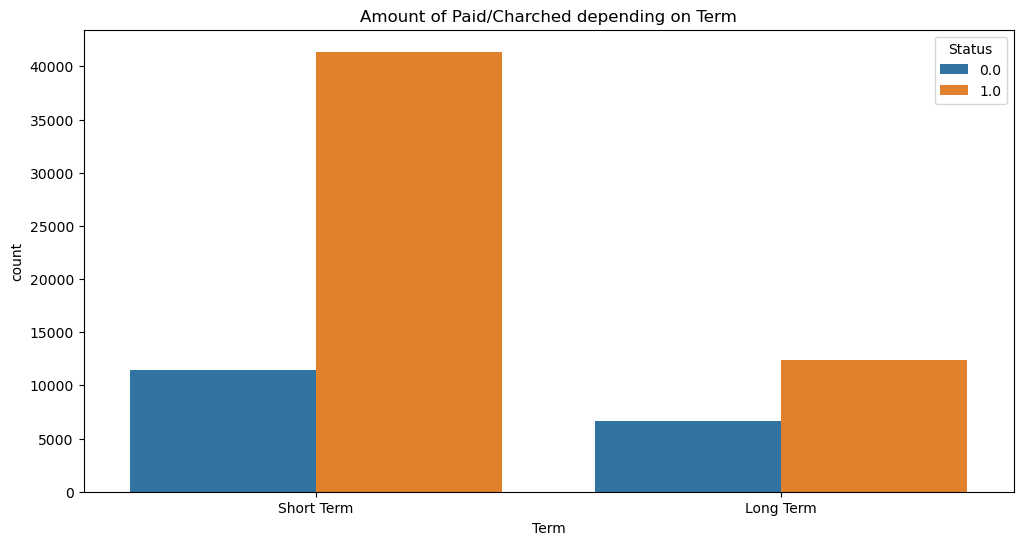

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x = X_train_cat["Term"], hue=y_train,ax=ax)
ax.set_title("Amount of Paid/Charched depending on Term")

In [35]:
def prob_class_zero_dist(X,y,class_name=0):
    percentage_list = pd.Series(index=X.unique(), dtype="float64")
    for cat in percentage_list.index:
        counts = X.value_counts()[cat]
        rows_zero = X[y == class_name][X == cat].count()
        percentage = np.round(rows_zero/counts*100,2)
        percentage_list[cat] = percentage
    return percentage_list

In [36]:
short_term_charged_off, long_term_charged_off = prob_class_zero_dist(X_train_cat["Term"].dropna(),y_train)
print("Short term charged off percentage: ",np.round(short_term_charged_off),"%")
print("Long Term charged off percentage: ",np.round(long_term_charged_off,2),"%")

Short term charged off percentage:  22.0 %
Long Term charged off percentage:  35.09 %


Short Term credits are frequently returned!

In [37]:
years_percentage = X_train_cat["Years in current job"].value_counts()/X_train_cat["Years in current job"].shape[0]*100
print("Years in a current job percentage in data:")
print(np.round(years_percentage,2))

Years in a current job percentage in data:
10 years or more    30.92
2 years              9.16
less than 1 year     8.19
3 years              8.18
5 years              6.87
1 year               6.46
4 years              6.10
6 years              5.77
7 years              5.58
8 years              4.57
9 years              3.95
Name: Years in current job, dtype: float64


Text(0.5, 1.0, 'Amount of Paid/Charged depending on years in current job')

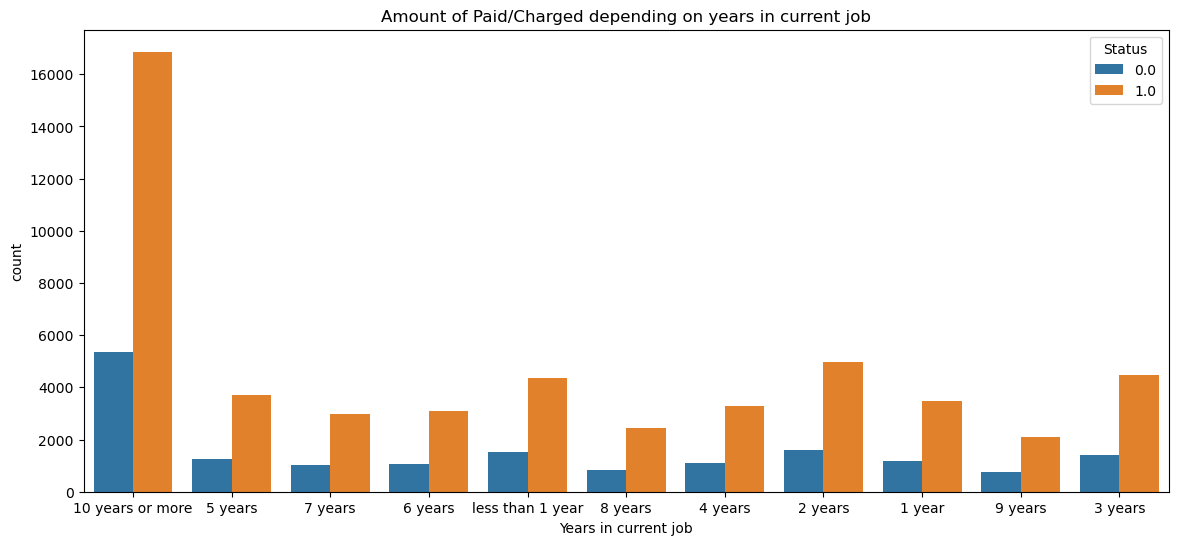

In [38]:
fig, ax = plt.subplots(figsize=(14,6))
sns.countplot(x = X_train_cat["Years in current job"], hue = y_train, ax = ax)
ax.set_title("Amount of Paid/Charged depending on years in current job")

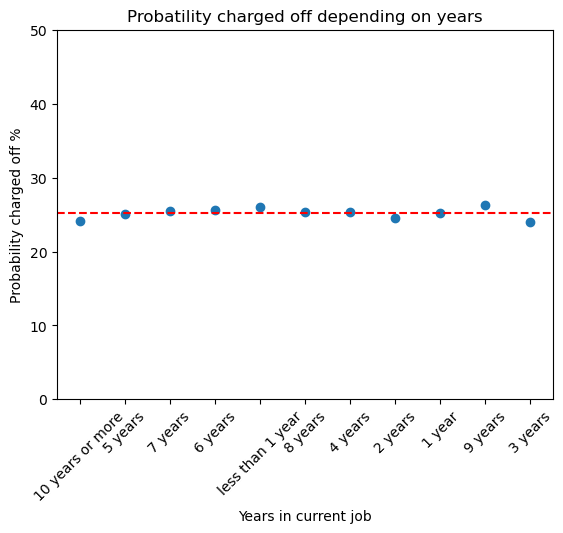

In [39]:
years_charged_off_prob = prob_class_zero_dist(X_train_cat["Years in current job"].dropna(),
                                             y_train)

plt.scatter(years_charged_off_prob.index,years_charged_off_prob)
plt.ylim([0,50])
plt.xticks(rotation=45)
plt.title("Probatility charged off depending on years")
plt.xlabel("Years in current job")
plt.ylabel("Probability charged off %")
plt.axhline(np.mean(years_charged_off_prob),linestyle="--",c="r")
plt.show()

So, probability of charge off depending on years is constant.

In [40]:
home_percentage = X_train_cat["Home Ownership"].value_counts()/X_train_cat["Home Ownership"].count()*100
print("Home Ownership percentage in data:")
print(np.round(home_percentage,2))

Home Ownership percentage in data:
Home Loan        48.62
Rent             42.02
Own Home          9.17
Mortgage Loan     0.19
Name: Home Ownership, dtype: float64


Text(0.5, 1.0, 'Amount of Paid/Charged off depending on Homw Ownership')

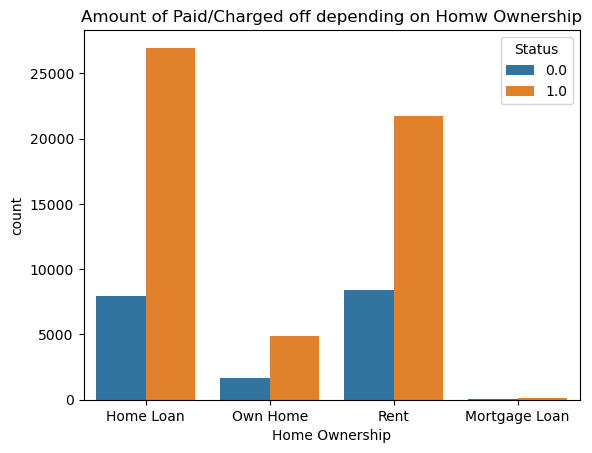

In [41]:
sns.countplot(x = X_train_cat["Home Ownership"], hue=y_train)
plt.title("Amount of Paid/Charged off depending on Homw Ownership")

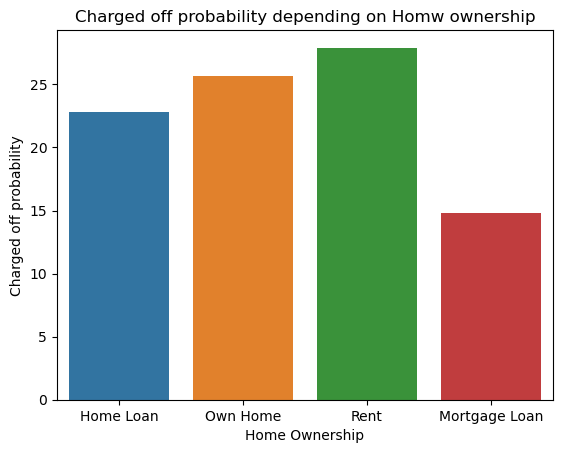

In [42]:
home_own_prob = prob_class_zero_dist(X_train_cat["Home Ownership"].dropna(),y_train)
sns.barplot(x = home_own_prob.index, y = home_own_prob)

plt.xlabel("Home Ownership")
plt.ylabel("Charged off probability")
plt.title("Charged off probability depending on Homw ownership")
plt.show()

Cgarged off probability are different for different home ownership

In [43]:
purpose_percentage = np.round(X_train_cat["Purpose"].value_counts()/X_train_cat.shape[0]*100,2)
print("Purpose percentage in data:")
print(np.round(purpose_percentage,2))

Purpose percentage in data:
Debt Consolidation      78.79
Other                    9.15
Home Improvements        5.86
Business Loan            1.50
Buy a Car                1.31
Medical Bills            1.09
Buy House                0.64
Take a Trip              0.53
Major Purchase           0.36
Small Business           0.28
Moving                   0.15
Wedding                  0.12
Vacation                 0.10
Educational Expenses     0.09
Renewable Energy         0.01
Name: Purpose, dtype: float64


Purpose categories are very imbalanced.

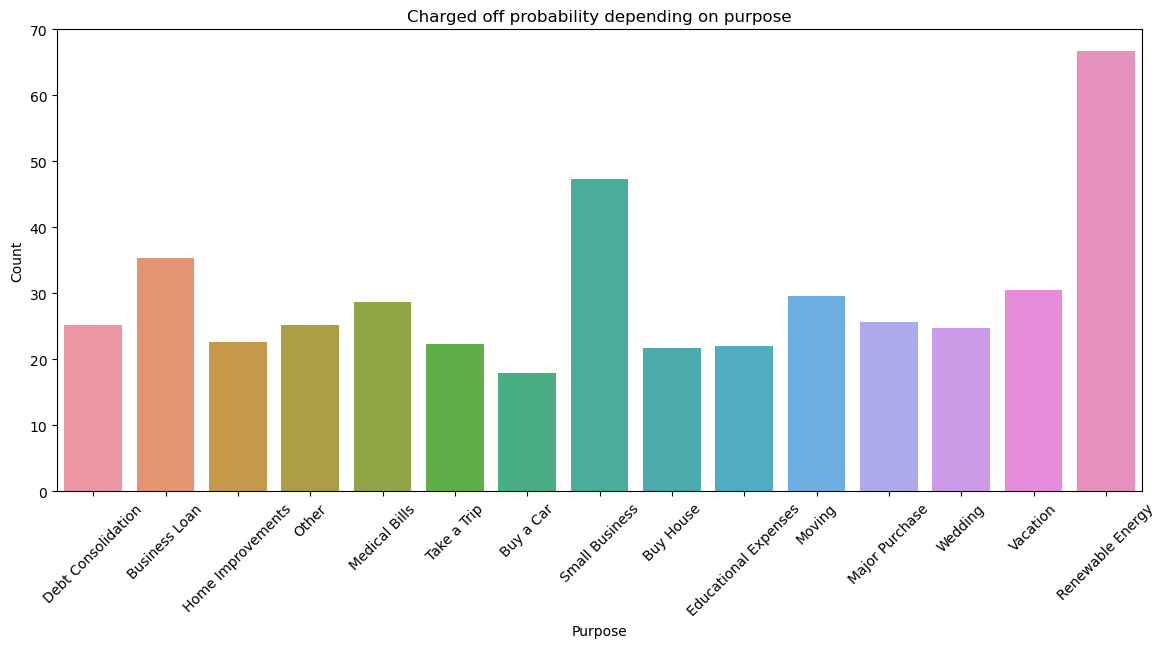

In [44]:
fig,ax = plt.subplots(figsize=(14,6))
purpose_prob = prob_class_zero_dist(X_train_cat["Purpose"].dropna(),y_train)
sns.barplot(x = purpose_prob.index, y = purpose_prob, ax=ax)
ax.set_xlabel("Purpose")
ax.set_ylabel("Count")
ax.set_title("Charged off probability depending on purpose")
plt.xticks(rotation=45)
plt.show()

# Categorical features preprocassing

In [45]:
X_train_cat.head()

,Term,Years in current job,Home Ownership,Purpose
17963,Short Term,10 years or more,Home Loan,Debt Consolidation
89243,Long Term,5 years,Home Loan,Debt Consolidation
50210,Long Term,10 years or more,Home Loan,Debt Consolidation
3393,Short Term,10 years or more,Home Loan,Debt Consolidation
74030,Short Term,5 years,Own Home,Debt Consolidation


In [47]:
X_train_cat.isna().sum()

Term                       0
Years in current job    3055
Home Ownership             0
Purpose                    0
dtype: int64

Impute as the most frequent

In [48]:
from sklearn.impute import SimpleImputer

cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat[:] = cat_imputer.fit_transform(X_train_cat)

In [49]:
from sklearn.preprocessing import OneHotEncoder
cat_columns = X_train_cat.columns

In [50]:
ohe_cat = OneHotEncoder()
ohe_data = ohe_cat.fit_transform(X_train_cat[cat_columns])
X_train_ohe = pd.DataFrame(data = ohe_data.toarray(), index = X_train_cat.index , columns = pd.Index(ohe_cat.get_feature_names_out())).astype('int')

In [51]:
X_train_cat_transformed = X_train_ohe
X_train_cat_transformed.head()

,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10 years or more,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,...,Purpose_Home Improvements,Purpose_Major Purchase,Purpose_Medical Bills,Purpose_Moving,Purpose_Other,Purpose_Renewable Energy,Purpose_Small Business,Purpose_Take a Trip,Purpose_Vacation,Purpose_Wedding
17963,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89243,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
50210,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3393,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74030,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Float features analysis/visualization

In [52]:
X_train_float = X_train.select_dtypes(exclude="object")

In [53]:
nan_values_percentage = np.round(X_train_float.isna().sum(axis=0)/X_train.shape[0]*100,2)
print("NaN values percentage in data:")
print(nan_values_percentage)

NaN values percentage in data:
Current Loan Amount              0.00
Credit Score                    21.36
Annual Income                   21.36
Monthly Debt                     0.00
Years of Credit History          0.00
Months since last delinquent    53.93
Number of Open Accounts          0.00
Number of Credit Problems        0.00
Current Credit Balance           0.00
Maximum Open Credit              0.00
Bankruptcies                     0.22
Tax Liens                        0.01
dtype: float64


Month since last delinquent has more than 50% Nan => drop this feature

In [54]:
drop_columns_float = ["Months since last delinquent"]
X_train_float.drop(drop_columns_float,axis=1,inplace=True)

In [55]:
X_train_float.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
17963,99999999.0,731.0,1320291.0,15733.52,18.0,12.0,0.0,267938.0,534908.0,0.0,0.0
89243,618266.0,6700.0,1216114.0,21180.82,14.9,10.0,0.0,436715.0,649132.0,0.0,0.0
50210,766854.0,6800.0,1759761.0,20383.77,26.8,15.0,0.0,301492.0,897402.0,0.0,0.0
3393,131780.0,NaN,NaN,31868.89,16.8,10.0,0.0,234365.0,347028.0,0.0,0.0
74030,110286.0,702.0,952470.0,11826.36,12.6,11.0,2.0,79933.0,384032.0,1.0,1.0


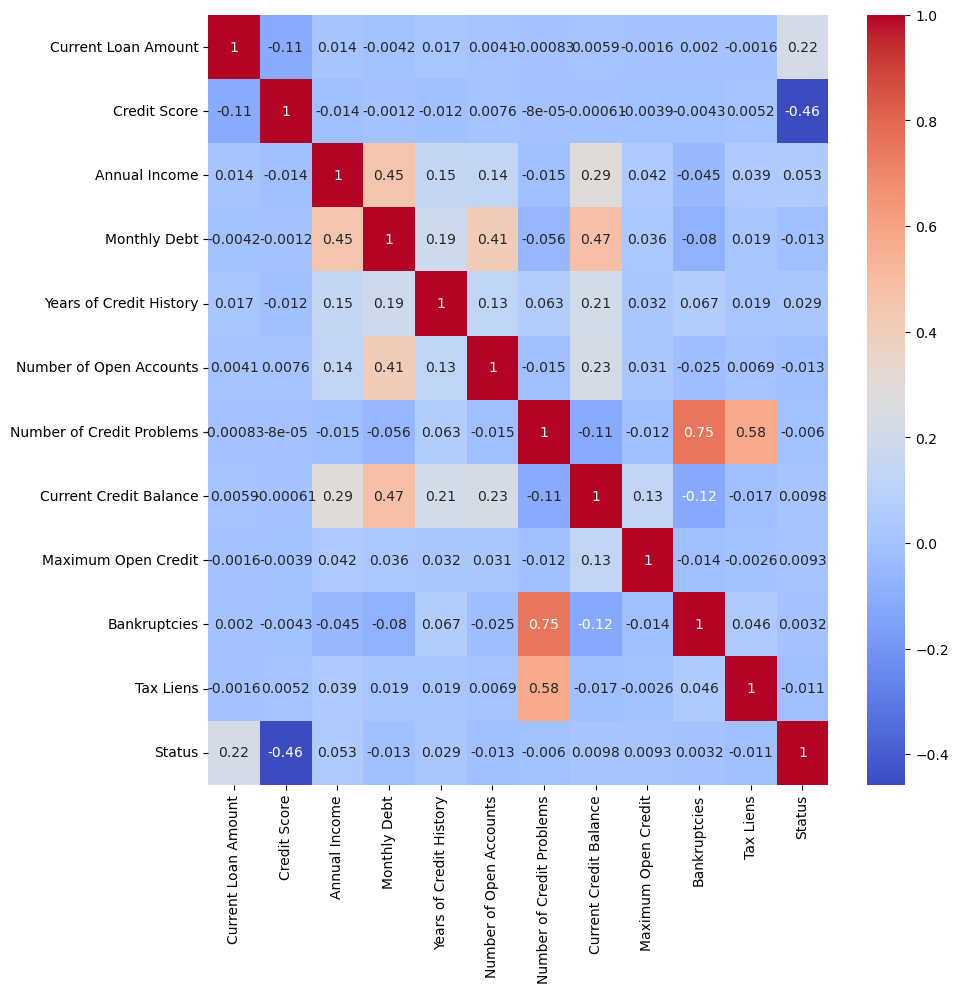

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pd.concat([X_train_float,y_train],axis=1).corr(),annot=True, cmap="coolwarm",ax=ax)
plt.show()

In [58]:
def plot_discrete_feature(X):
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    distr = X.value_counts()
    ax[0].scatter(distr.index,distr)
    ax[0].set_xlabel(X.name)
    ax[0].set_ylabel("Amount of events")
    sns.boxplot(x = X,ax=ax[1])

In [59]:
def plot_float_feature(X):
    nbins = int(1 + 3.322*np.log(X.count()))
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    sns.histplot(X,ax=ax[0],bins=nbins)
    ax[0].set_ylabel("Amount of events")
    sns.boxplot(x = X,ax=ax[1])

In [60]:
def drop_outliers(X,std_th = 4):
    mean = X.mean()
    std = X.std()
    drop_index = X[(X - mean)/std > std_th].index
    return np.array(drop_index)

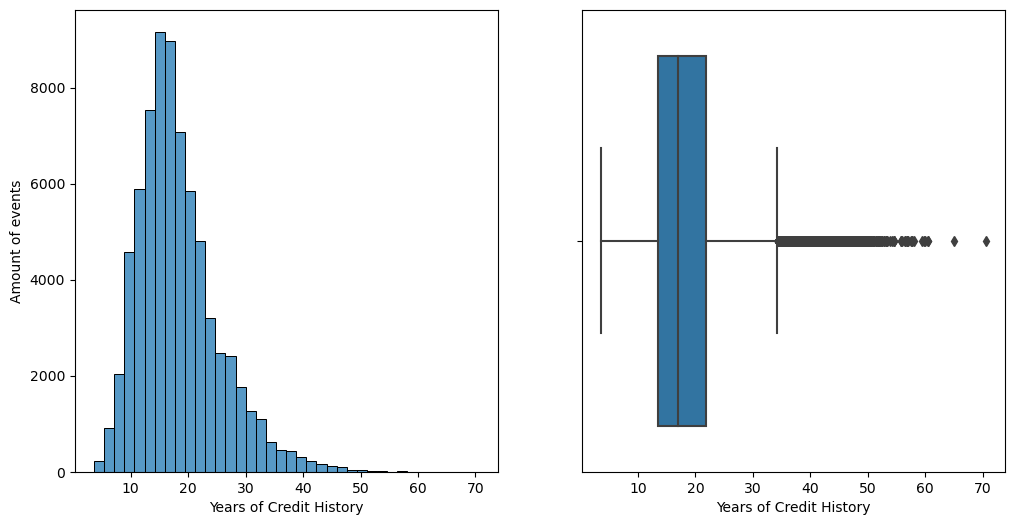

In [61]:
plot_float_feature(X_train_float["Years of Credit History"])

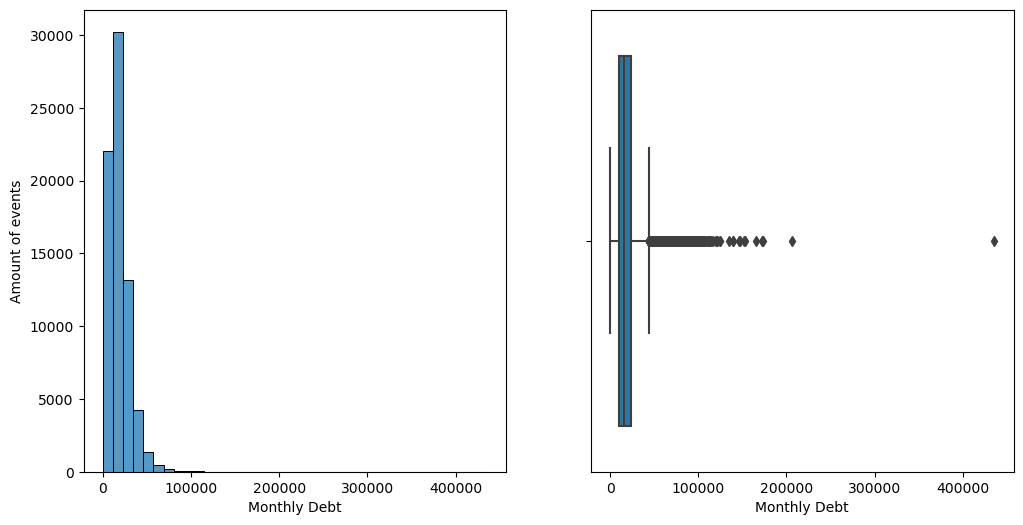

In [62]:
plot_float_feature(X_train_float["Monthly Debt"])

Drop outliers values

In [63]:
drop_index_monthly_debt = drop_outliers(X_train_float["Monthly Debt"])

In [64]:
print("Number of outliers in 'Monthly Debt' feature: ",drop_index_monthly_debt.shape[0])

Number of outliers in 'Monthly Debt' feature:  385


In [65]:
X_train_float.drop(drop_index_monthly_debt,axis=0,inplace=True)

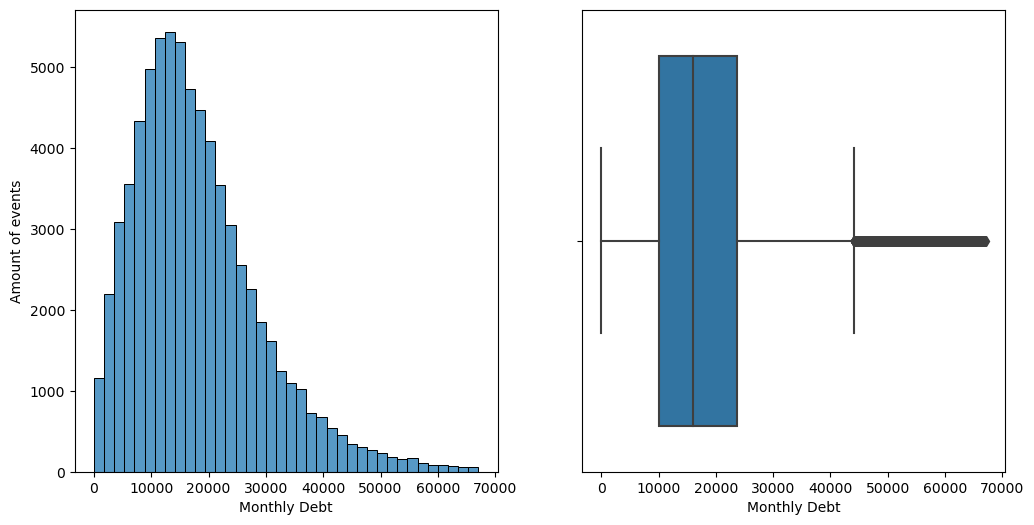

In [66]:
plot_float_feature(X_train_float["Monthly Debt"])

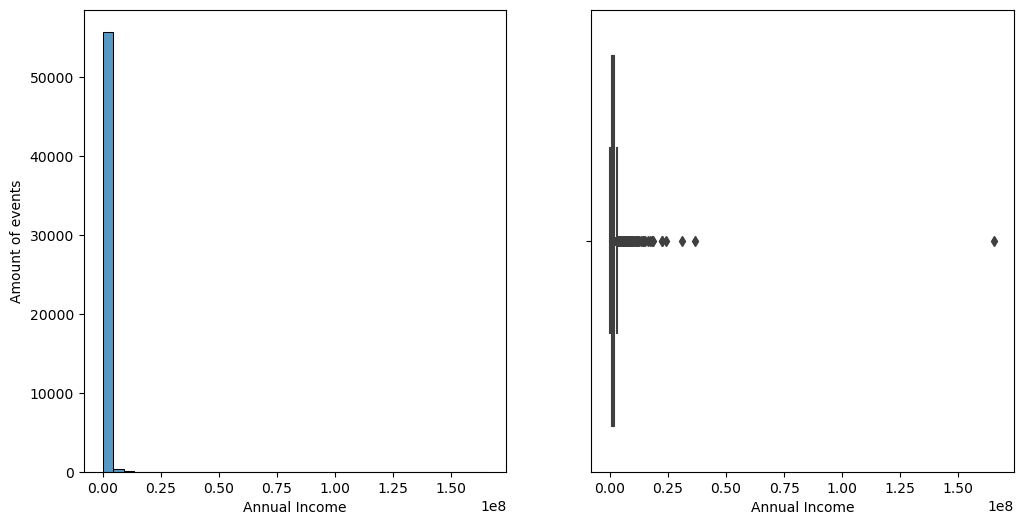

In [67]:
plot_float_feature(X_train_float["Annual Income"])

Do the same with this feature

In [68]:
drop_index_annual_income = drop_outliers(X_train_float["Annual Income"])
print("Amount of outliers in Annual Income feature: ", drop_index_annual_income.shape[0])

Amount of outliers in Annual Income feature:  179


In [69]:
X_train_float.drop(drop_index_annual_income,axis=0,inplace=True)

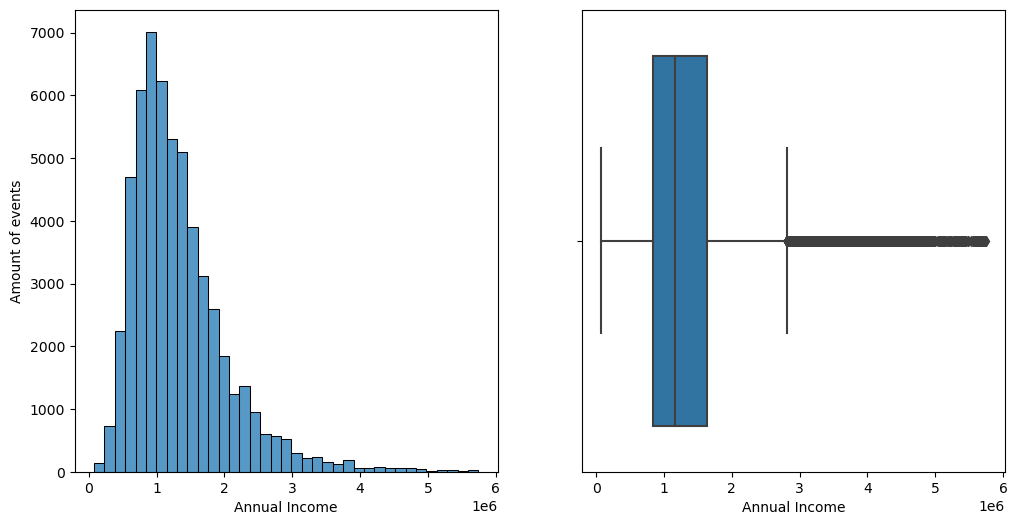

In [70]:
plot_float_feature(X_train_float["Annual Income"])

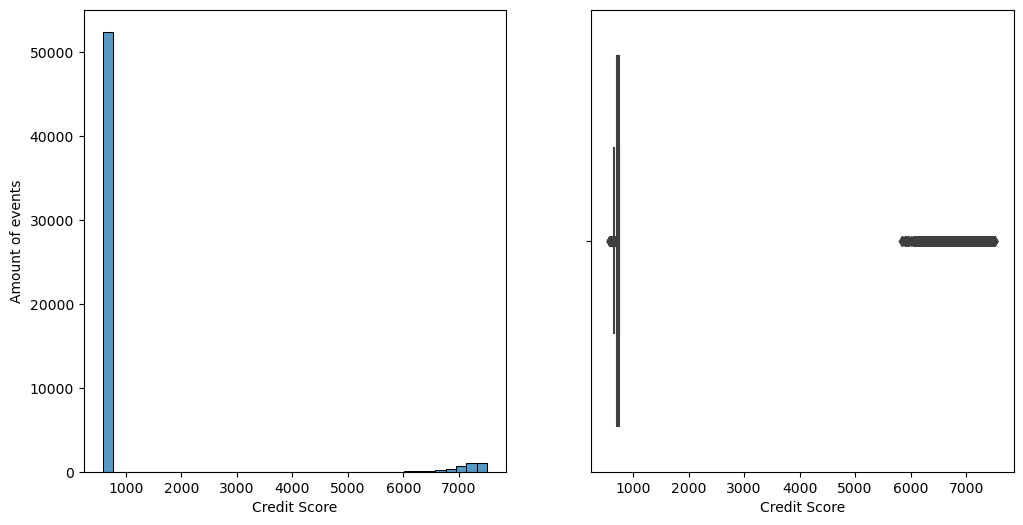

In [71]:
plot_float_feature(X_train_float["Credit Score"])

There are two distribution clusters. Plot them

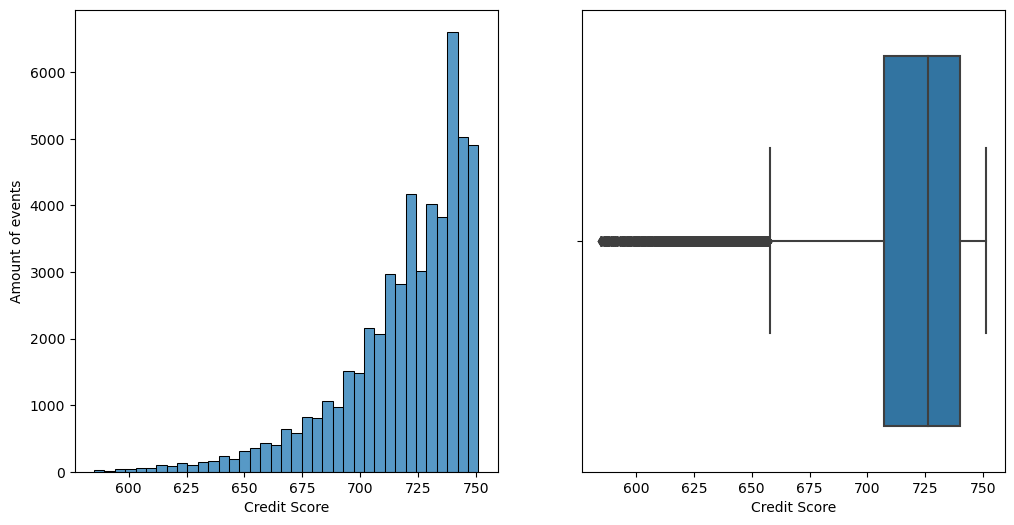

In [72]:
X_train_float[X_train_float["Credit Score"] < 4000]
plot_float_feature(X_train_float[X_train_float["Credit Score"] < 4000]["Credit Score"])

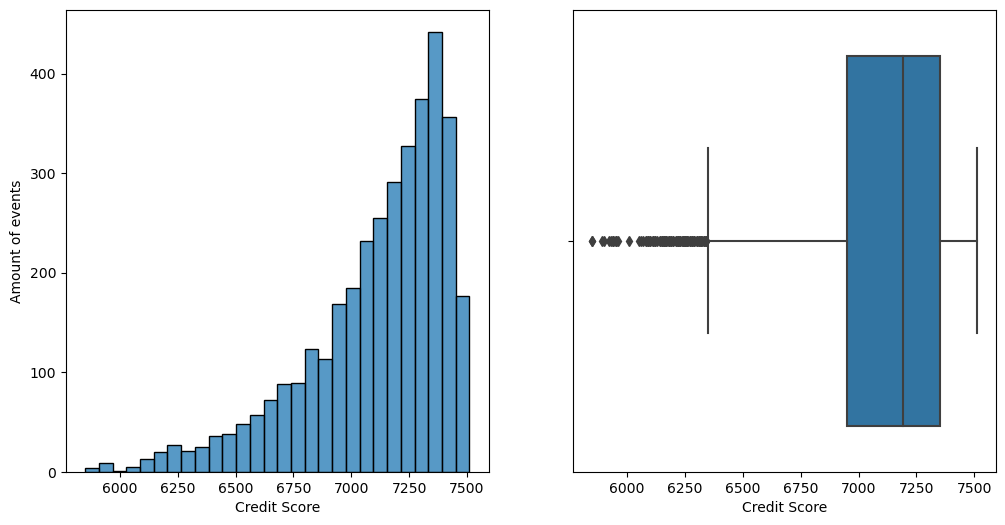

In [73]:
plot_float_feature(X_train_float[X_train_float["Credit Score"] > 4000]["Credit Score"])

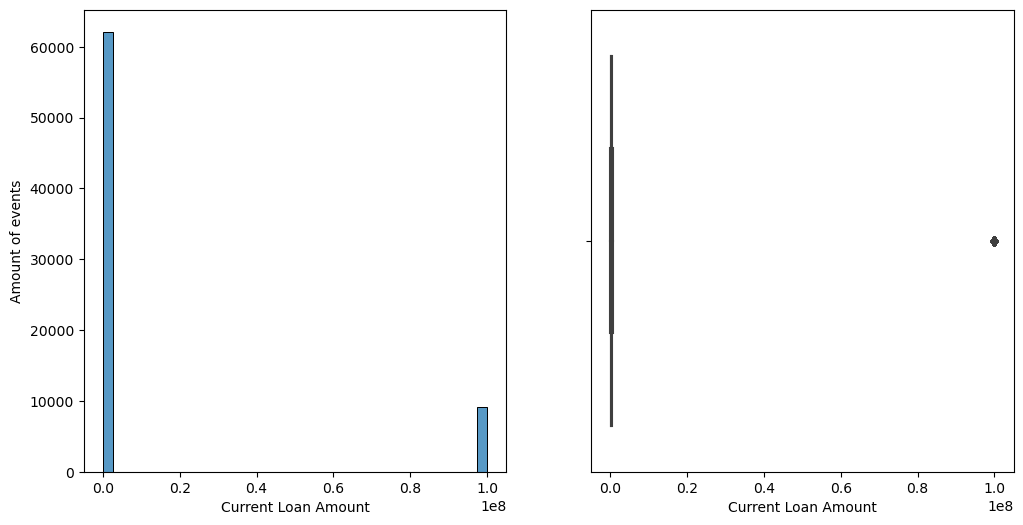

In [74]:
plot_float_feature(X_train_float["Current Loan Amount"])

There are two distr too

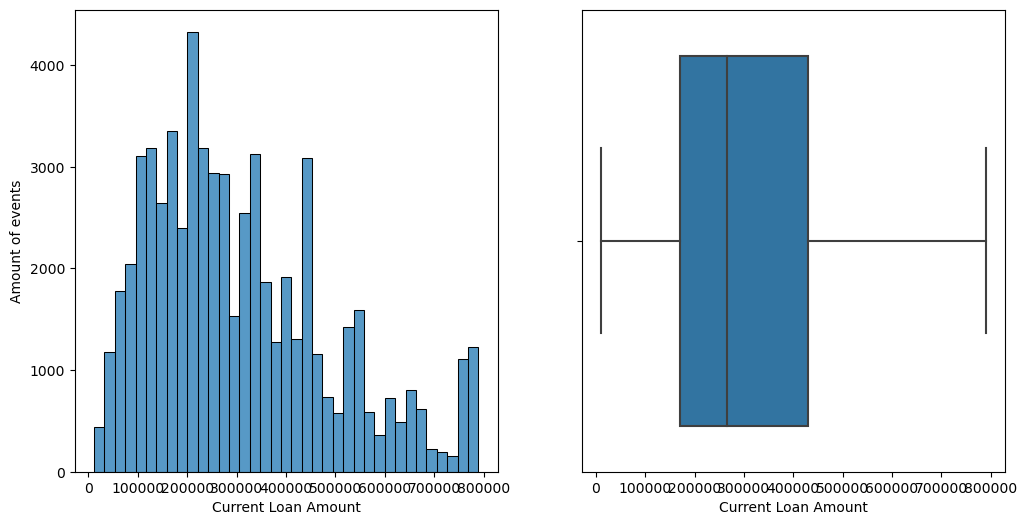

In [75]:
plot_float_feature(X_train_float["Current Loan Amount"][X_train_float["Current Loan Amount"] < 0.8*10**8])

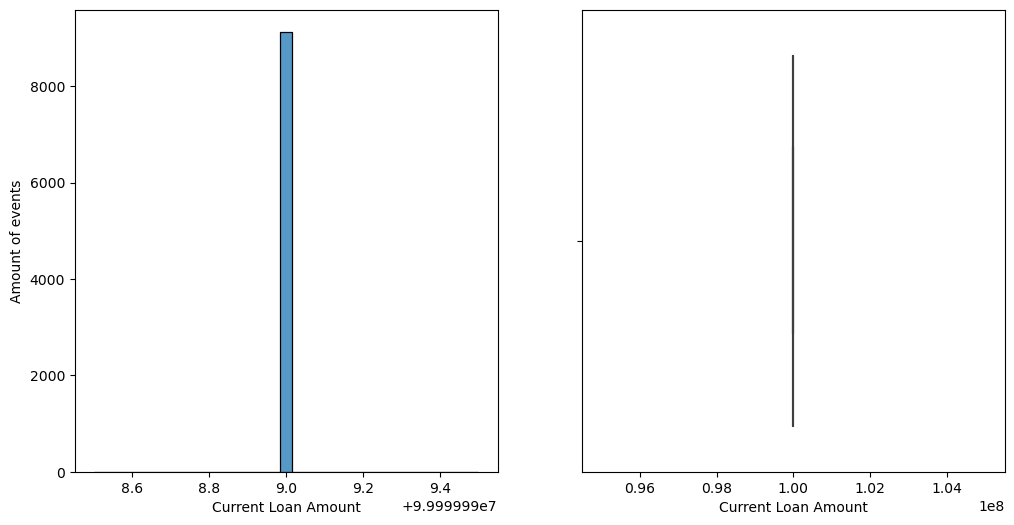

In [76]:
plot_float_feature(X_train_float["Current Loan Amount"][X_train_float["Current Loan Amount"] > 0.8*10**8])

In [77]:
max_loan_amount = X_train_float["Current Loan Amount"].max()
max_loan_amount

99999999.0

There are more than 8k rows with Current Loan Amount equal to 99999999. \
I think it is maximun amount that bank could give. So I have dicided to keep such rows.

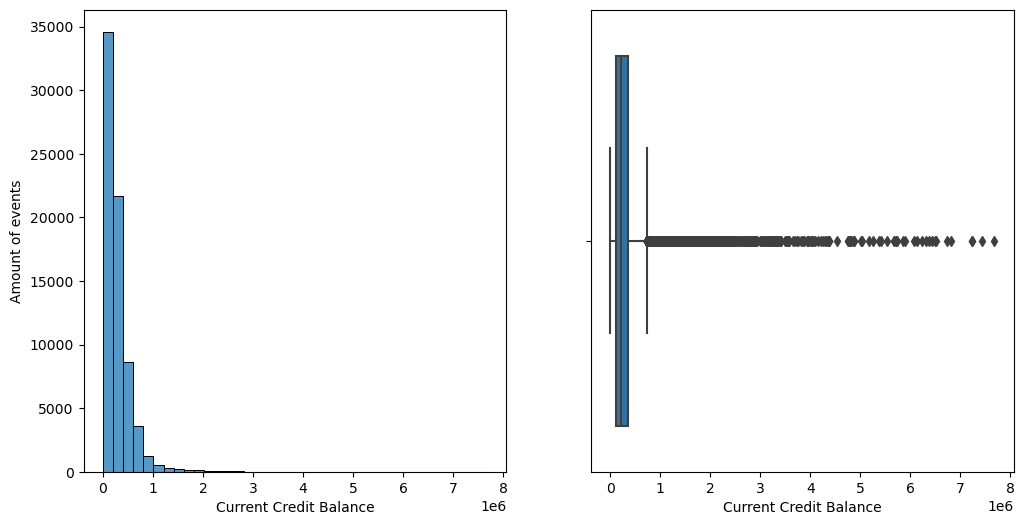

In [78]:
plot_float_feature(X_train_float["Current Credit Balance"])

In [79]:
drop_index_credit_balance = drop_outliers(X_train_float["Current Credit Balance"])
print("Amount of outliers in Current Credit Balance feature: ",drop_index_credit_balance.shape[0])

Amount of outliers in Current Credit Balance feature:  603


In [80]:
X_train_float.drop(drop_index_credit_balance,axis=0,inplace=True)

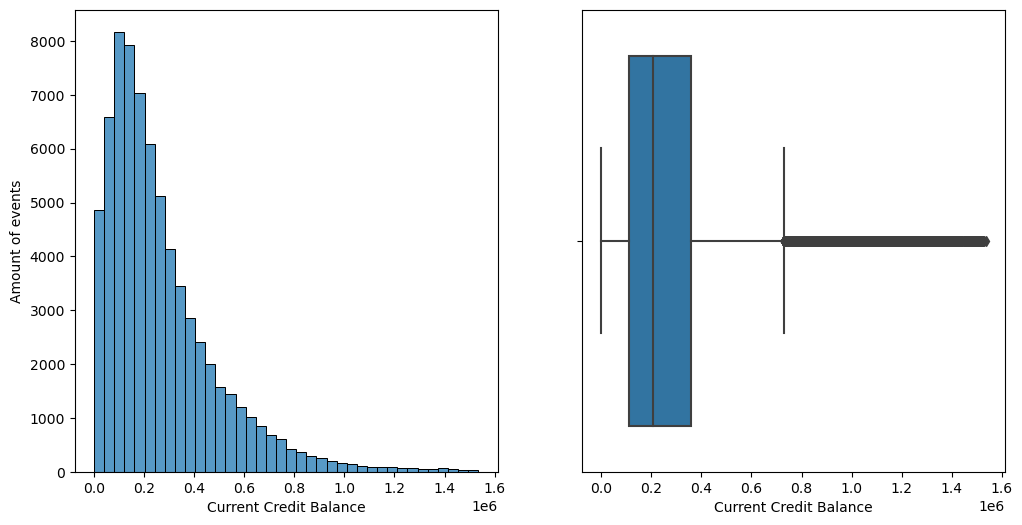

In [81]:
plot_float_feature(X_train_float["Current Credit Balance"])

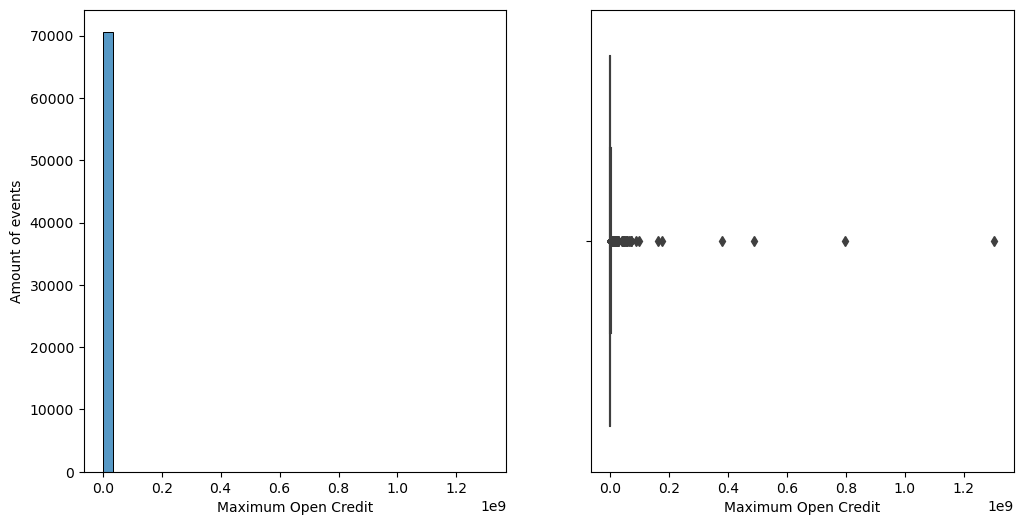

In [82]:
plot_float_feature(X_train_float["Maximum Open Credit"])

In [83]:
drop_index_open_credit = drop_outliers(X_train_float["Maximum Open Credit"])
print("Amount of outliers in Maximum open credit feature:", drop_index_open_credit.shape[0])

Amount of outliers in Maximum open credit feature: 27


In [84]:
X_train_float.drop(drop_index_open_credit,inplace=True)

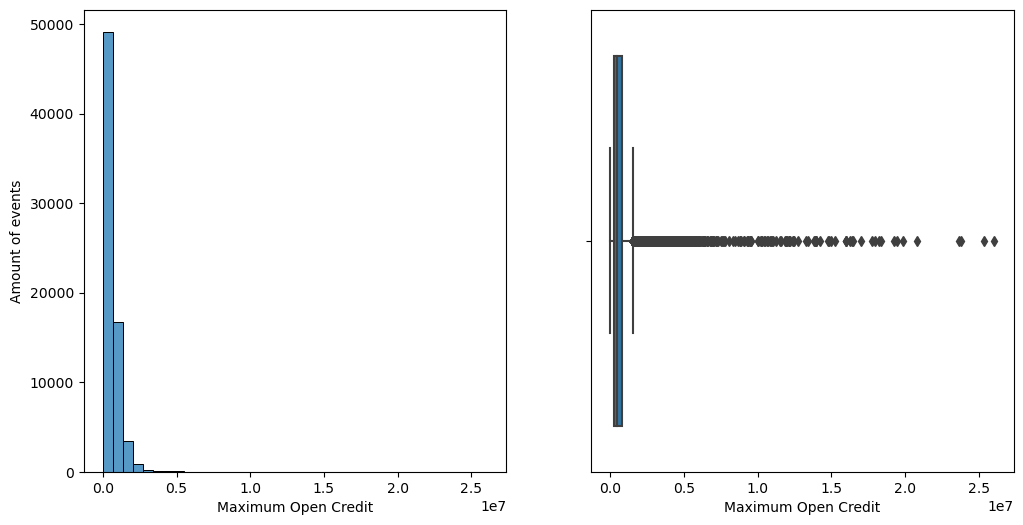

In [85]:
plot_float_feature(X_train_float["Maximum Open Credit"])

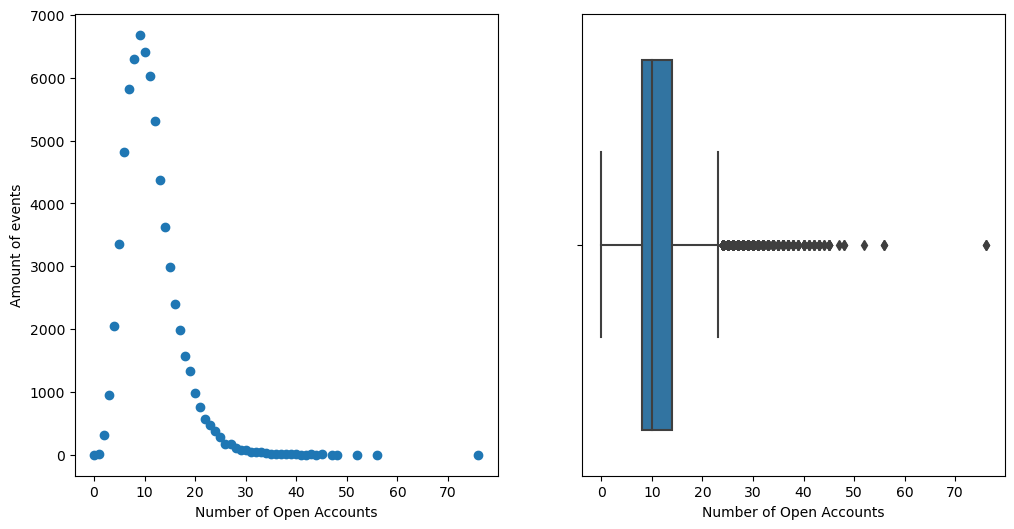

In [86]:
plot_discrete_feature(X_train_float["Number of Open Accounts"])

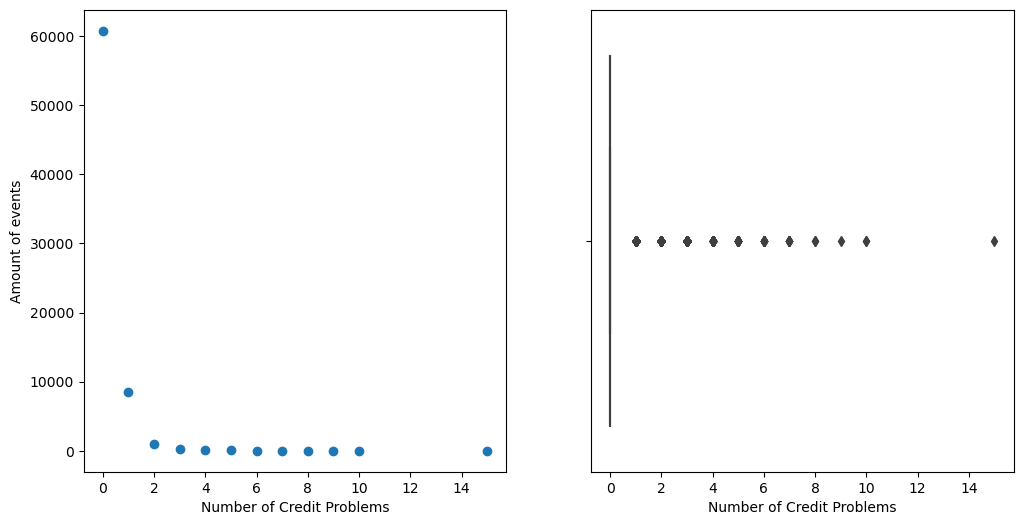

In [87]:
plot_discrete_feature(X_train_float["Number of Credit Problems"])

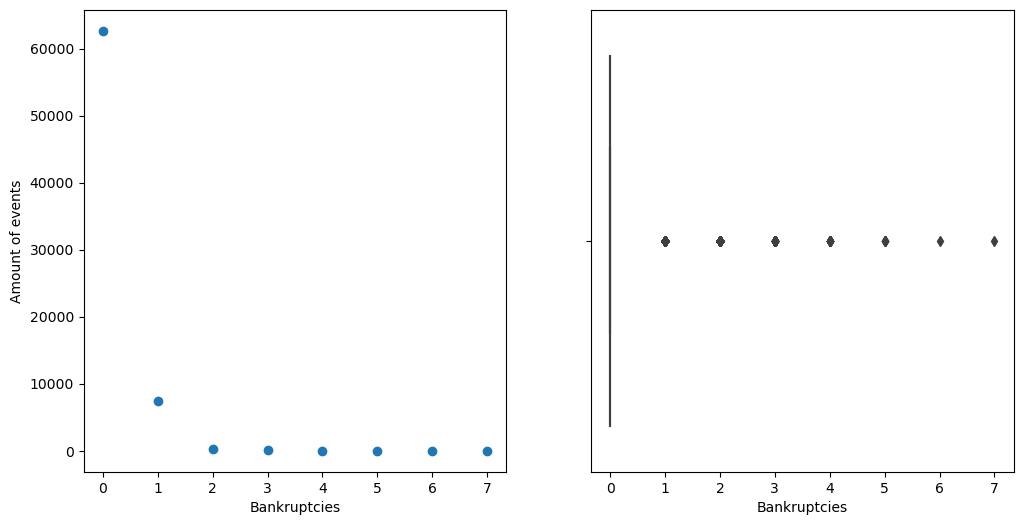

In [88]:
plot_discrete_feature(X_train_float["Bankruptcies"])

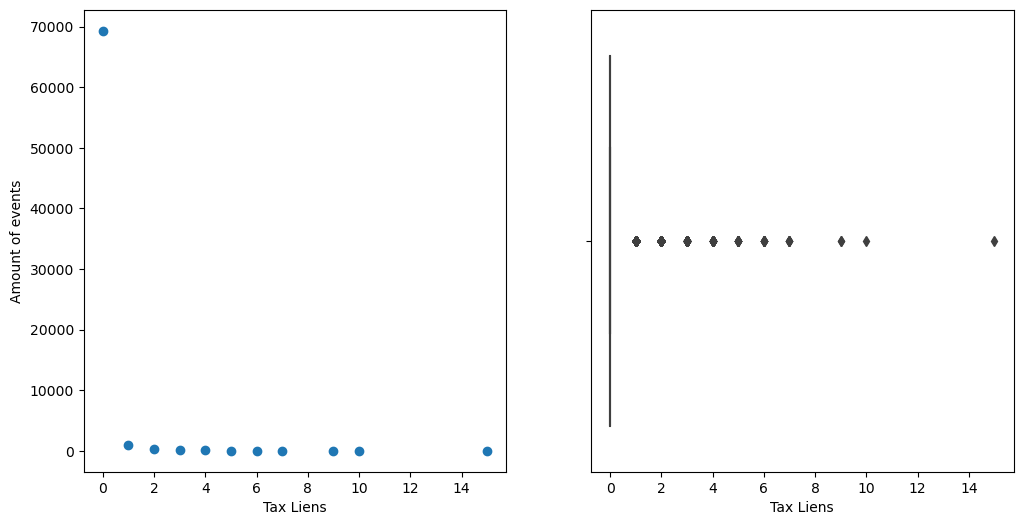

In [89]:
plot_discrete_feature(X_train_float["Tax Liens"])

In [90]:
X_train_float.isna().sum()

Current Loan Amount              0
Credit Score                 15125
Annual Income                15125
Monthly Debt                     0
Years of Credit History          0
Number of Open Accounts          0
Number of Credit Problems        0
Current Credit Balance           0
Maximum Open Credit              2
Bankruptcies                   148
Tax Liens                        6
dtype: int64

Impute NaN as a mean and most frequent

In [91]:
int_imp_columns=["Number of Open Accounts","Tax Liens","Bankruptcies","Number of Credit Problems"]
int_imputer = SimpleImputer(strategy="most_frequent")
X_train_float[int_imp_columns] = (int_imputer.fit_transform(X_train_float[int_imp_columns])).astype(int)

In [92]:
float_imp_columns = [x for x in X_train_float.columns if x not in int_imp_columns]
float_imputer = SimpleImputer(strategy="mean")
X_train_float[float_imp_columns] = float_imputer.fit_transform(X_train_float[float_imp_columns])

Scale float columns

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_float[float_imp_columns] = scaler.fit_transform(X_train_float[float_imp_columns])

collect dropped indeces

In [94]:
drop_index = [x for x in X_train_cat_transformed.index if x not in X_train_float.index]
print("Total amount of dropped rows:",len(drop_index))

Total amount of dropped rows: 1194


In [95]:
X_train_cat_transformed.drop(drop_index,inplace=True)

In [96]:
X_train_transformed = pd.concat([X_train_cat_transformed,X_train_float],axis=1)

In [97]:
y_train.drop(drop_index,inplace=True)

In [98]:
X_train_transformed.head()

,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10 years or more,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,...,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
17963,0,1,0,1,0,0,0,0,0,0,...,0.021083,0.219469,0.234747,0.215247,12,0,0.174575,0.020518,0,0
89243,1,0,0,0,0,0,0,1,0,0,...,0.883032,0.201085,0.316022,0.168909,10,0,0.284542,0.024900,0,0
50210,1,0,0,1,0,0,0,0,0,0,...,0.897473,0.297022,0.304130,0.346786,15,0,0.196437,0.034423,0,0
3393,0,1,0,1,0,0,0,0,0,0,...,0.078821,0.219432,0.475490,0.197309,10,0,0.152701,0.013311,0,0
74030,0,1,0,0,0,0,0,1,0,0,...,0.016895,0.154560,0.176452,0.134529,11,2,0.052080,0.014731,1,1


In [99]:
X_train_transformed.columns

Index(['Term_Long Term', 'Term_Short Term', 'Years in current job_1 year',
       'Years in current job_10 years or more', 'Years in current job_2 years',
       'Years in current job_3 years', 'Years in current job_4 years',
       'Years in current job_5 years', 'Years in current job_6 years',
       'Years in current job_7 years', 'Years in current job_8 years',
       'Years in current job_9 years', 'Years in current job_less than 1 year',
       'Home Ownership_Home Loan', 'Home Ownership_Mortgage Loan',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Purpose_Business Loan', 'Purpose_Buy House', 'Purpose_Buy a Car',
       'Purpose_Debt Consolidation', 'Purpose_Educational Expenses',
       'Purpose_Home Improvements', 'Purpose_Major Purchase',
       'Purpose_Medical Bills', 'Purpose_Moving', 'Purpose_Other',
       'Purpose_Renewable Energy', 'Purpose_Small Business',
       'Purpose_Take a Trip', 'Purpose_Vacation', 'Purpose_Wedding',
       'Current Loan Amoun

# Test data preprocessing

In [100]:
drop_columns = ["Months since last delinquent"]
X_test.drop(drop_columns,axis=1,inplace=True)

In [101]:
X_test.columns

Index(['Current Loan Amount', 'Term', 'Credit Score', 'Annual Income',
       'Years in current job', 'Home Ownership', 'Purpose', 'Monthly Debt',
       'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [102]:
X_test_cat = X_test.select_dtypes(include="object")

In [103]:
X_test_cat.isna().sum()

Term                      0
Years in current job    747
Home Ownership            0
Purpose                   0
dtype: int64

In [104]:
X_test_cat[:] = cat_imputer.transform(X_test_cat)

#X_test_cat_le = pd.DataFrame(index=X_test_cat.index, columns=le_columns)
#for le,col in zip(le_list,le_columns):
#    X_test_cat_le[col] = le.transform(X_test_cat[col])

In [105]:
ohe_test_data = ohe_cat.transform(X_test_cat[cat_columns])
X_test_cat_ohe = pd.DataFrame(data = ohe_test_data.toarray(),
                              index=X_test_cat.index,
                              columns=pd.Index(ohe_cat.get_feature_names_out()), dtype='int64')

In [106]:
X_test_cat_ohe

,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10 years or more,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,...,Purpose_Home Improvements,Purpose_Major Purchase,Purpose_Medical Bills,Purpose_Moving,Purpose_Other,Purpose_Renewable Energy,Purpose_Small Business,Purpose_Take a Trip,Purpose_Vacation,Purpose_Wedding
97736,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
77343,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14416,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19871,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11543,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96830,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78355,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11041,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
88513,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
X_test_cat_transformed = X_test_cat_ohe#pd.concat([X_test_cat_ohe,X_test_cat_le],axis=1)
X_test_cat_transformed.head()

,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10 years or more,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,...,Purpose_Home Improvements,Purpose_Major Purchase,Purpose_Medical Bills,Purpose_Moving,Purpose_Other,Purpose_Renewable Energy,Purpose_Small Business,Purpose_Take a Trip,Purpose_Vacation,Purpose_Wedding
97736,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
77343,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14416,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19871,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11543,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [108]:
X_test_float = X_test.select_dtypes(exclude="object")

X_test_float[int_imp_columns] = int_imputer.transform(X_test_float[int_imp_columns])

X_test_float[float_imp_columns] = float_imputer.transform(X_test_float[float_imp_columns])

X_test_float[float_imp_columns] = scaler.transform(X_test_float[float_imp_columns])

In [109]:
X_test_transformed = pd.concat([X_test_cat_transformed,X_test_float],axis=1)

In [110]:
X_test_transformed.head()

,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10 years or more,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,...,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
97736,0,1,0,0,0,0,0,1,0,0,...,0.010542,0.103961,0.206935,0.200299,11.0,0.0,0.353570,0.028223,0.0,0.0
77343,0,1,0,1,0,0,0,0,0,0,...,0.078821,0.219432,0.692656,0.294469,19.0,0.0,0.686255,0.099112,0.0,0.0
14416,0,1,1,0,0,0,0,0,0,0,...,0.078821,0.219432,0.106014,0.328849,4.0,0.0,0.052278,0.009846,0.0,0.0
19871,0,1,0,0,0,0,1,0,0,0,...,0.023249,0.536059,0.418195,0.209268,10.0,0.0,0.896966,0.073139,0.0,0.0
11543,0,1,0,0,0,1,0,0,0,0,...,0.022238,0.213736,0.010568,0.224215,7.0,0.0,0.001807,0.017645,0.0,0.0


# Baseline model RF

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, roc_curve

In [112]:
def model_eval(model,data,y, printing = False):
    test_proba = model.predict_proba(data)[:,1]
    test_labels = test_proba > 1/2
    
    roc_auc = np.round(roc_auc_score(y,test_labels),3)
    precision = np.round(precision_score(y,test_labels),3)
    acc = np.round(accuracy_score(y,test_labels),3)
    
    if printing:
        print("roc_auc: ", roc_auc)
        print("precision: ", precision)
        print("acc: ", acc)
        
    return roc_auc, precision, acc

In [113]:
rf_model = RandomForestClassifier(n_jobs=-1,n_estimators=1000)
rf_model.fit(X_train_transformed,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [114]:
model_eval(rf_model,X_test_transformed,y_test)

(0.618, 0.795, 0.802)

In [115]:
features_imp = pd.Series(dtype="float64")
for col_name, val in zip(X_train_transformed.columns,rf_model.feature_importances_):
    features_imp[col_name] = val

features_imp.sort_values(ascending=False, inplace=True)
features_imp

Credit Score                             0.203468
Current Loan Amount                      0.132153
Maximum Open Credit                      0.096534
Monthly Debt                             0.095515
Current Credit Balance                   0.094428
Years of Credit History                  0.089884
Annual Income                            0.077255
Number of Open Accounts                  0.063559
Years in current job_10 years or more    0.009978
Number of Credit Problems                0.009393
Term_Short Term                          0.009238
Term_Long Term                           0.008509
Purpose_Debt Consolidation               0.007678
Bankruptcies                             0.006984
Years in current job_2 years             0.006702
Years in current job_less than 1 year    0.006458
Years in current job_3 years             0.005945
Years in current job_5 years             0.005942
Purpose_Other                            0.005783
Years in current job_4 years             0.005689


In [116]:
roc_auc_list = []
precision_list = []
acc_list = []
for k in np.arange(2,features_imp.shape[0] + 1):
    features_name = features_imp.index[:k]
    X = X_train_transformed[features_name]
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators = 100)
    rf.fit(X,y_train)
    
    roc_auc, precision, acc = model_eval(rf,X_test_transformed[features_name],y_test)
    
    roc_auc_list.append(roc_auc)
    precision_list.append(precision)
    acc_list.append(acc)

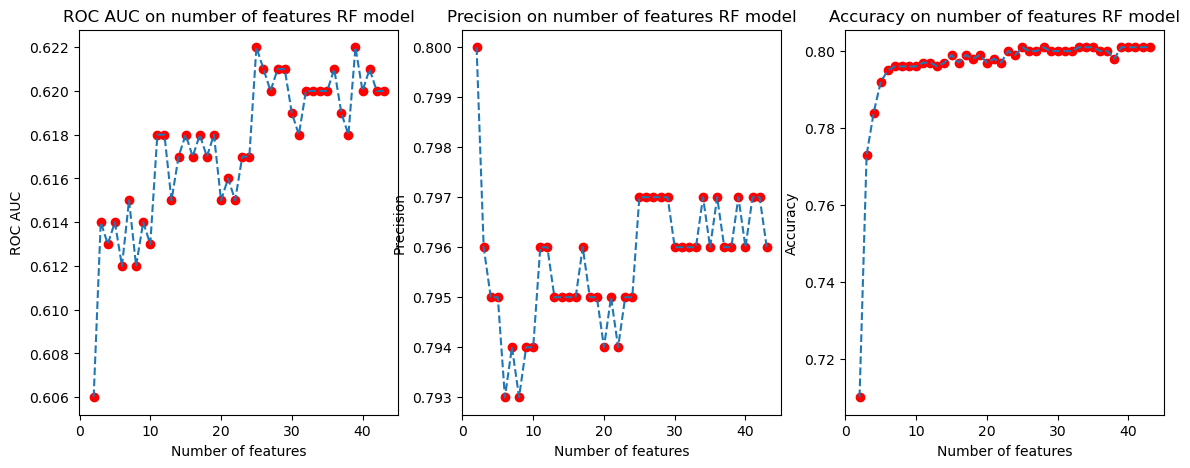

In [117]:
fig, ax = plt.subplots(1,3,figsize=(14,5))
ax[0].plot(np.arange(2,features_imp.shape[0] + 1),roc_auc_list, linestyle='--')
ax[0].scatter(np.arange(2,features_imp.shape[0] + 1),roc_auc_list,c = 'r')
ax[0].set_title("ROC AUC on number of features RF model")
ax[0].set_xlabel("Number of features")
ax[0].set_ylabel("ROC AUC")

ax[1].plot(np.arange(2,features_imp.shape[0] + 1),precision_list, linestyle="--")
ax[1].scatter(np.arange(2,features_imp.shape[0] + 1),precision_list,c = 'r')
ax[1].set_xlabel("Number of features")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision on number of features RF model")

ax[2].plot(np.arange(2,features_imp.shape[0] + 1),acc_list, linestyle="--")
ax[2].scatter(np.arange(2,features_imp.shape[0] + 1),acc_list,c = 'r')
ax[2].set_xlabel("Number of features")
ax[2].set_ylabel("Accuracy")
ax[2].set_title("Accuracy on number of features RF model")

plt.show()

So, Take all features

# Model hyperpars

In [100]:
from sklearn.model_selection import GridSearchCV

In [233]:
clf = xgb.XGBClassifier(objective="binary:logistic", max_depth=10)
params = {
    'n_estimators': [10,50,100,200,300,400,500],
    'learning_rate': [0.01,0.1,0.2,0.3],
}

gs_cv = GridSearchCV(estimator= clf, param_grid=params, scoring="precision", n_jobs=-1)
gs_cv.fit(X_train_transformed, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=10,
                                     max_leaves=None, min_child_we

In [237]:
pd.DataFrame(gs_cv.cv_results_)[["param_learning_rate","param_n_estimators","mean_test_score"]]

,param_learning_rate,param_n_estimators,mean_test_score
0,0.01,10,0.793122
1,0.01,50,0.792485
2,0.01,100,0.791830
3,0.01,200,0.791958
4,0.01,300,0.792005
5,0.01,400,0.792333
6,0.01,500,0.792980
7,0.1,10,0.791961
8,0.1,50,0.793510
9,0.1,100,0.795349


In [238]:
print(gs_cv.best_params_)
print(np.round(gs_cv.best_score_,3))

{'learning_rate': 0.3, 'n_estimators': 500}
0.805


Move right border of the parameters area

In [239]:
clf = xgb.XGBClassifier(objective="binary:logistic", max_depth=10)
params = {
    'n_estimators': [400,500,700,900,1000],
    'learning_rate': [0.2,0.3,0.4,0.5,0.7,0.9],
}

gs_cv = GridSearchCV(estimator= clf, param_grid=params, scoring="precision", n_jobs=-1)
gs_cv.fit(X_train_transformed, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=10,
                                     max_leaves=None, min_child_we

In [241]:
print(gs_cv.best_score_)
print(gs_cv.best_params_)

0.8080227763523867
{'learning_rate': 0.9, 'n_estimators': 900}


In [118]:
model = xgb.XGBClassifier(objective="binary:logistic", max_depth=10, learning_rate="0.9", n_estimators = 900)
model.fit(X_train_transformed,y_train)
model_eval(model,X_test_transformed,y_test)

(0.641, 0.811, 0.772)

# Make Pipeline

In [119]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [120]:
float_transformer = Pipeline(
    steps = [
        ("float_imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler())
    ]
)

cat_transformer = Pipeline(
    steps = [
        ("cat_imputer",SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder()),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transformer", cat_transformer, cat_columns),
        ("integer_transformer",SimpleImputer(strategy="most_frequent"),int_imp_columns),
        ("float_transformer",float_transformer, float_imp_columns),
    ]
)

In [121]:
clf = xgb.XGBClassifier(objective="binary:logistic", 
                        max_depth=10, 
                        learning_rate="0.9", 
                        n_estimators = 900)

pipe = Pipeline(
    [("preprocessor", preprocessor),
     ("clf",clf)
    ]
)

In [122]:
X_train_pipe = X_train.drop(["Months since last delinquent"],axis=1)
X_train_pipe.drop(drop_index,axis=0,inplace=True)

In [123]:
pipe.fit(X_train_pipe,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_transformer',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  Index(['Term', 'Years in current job', 'Home Ownership', 'Purpose'], dtype='object')),
                                                 ('integer_transformer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Number of Open Accounts',
                                                   'Tax...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate='0.9', max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=900, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [124]:
X_test_pipe = pipe["preprocessor"].transform(X_test)

In [125]:
model_eval(pipe["clf"],X_test_pipe,y_test)

(0.64, 0.811, 0.771)

In [126]:
import joblib

joblib.dump(pipe, 'bank_loan_model_pipepline.pkl')

['bank_loan_model_pipepline.pkl']

In [128]:
pipe_loaded = joblib.load('bank_loan_model_pipepline.pkl')

In [129]:
row = pd.DataFrame(data = X_test.iloc[0,:].to_numpy().reshape(1,-1),
                          columns=X_test.columns)

In [131]:
pipe_loaded.predict_proba(row)

array([[0.26277608, 0.7372239 ]], dtype=float32)